In [ ]:
# Install libraries
!pip install transformers torch --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [6]:
# Import PyTorch and Transformers components
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

# For data handling and metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [7]:
# 2 Load and prepare the dataset
# Load your dataset
df = pd.read_csv("filtered_dataset.csv")

# Extract tweets and labels
tweets = df["tweet"].tolist()
labels = df["sentiment"].tolist()  # where 0 = bullish, 1 = neutral, 2 = bearish

In [8]:
# 3. Load Pre-trained FinTwitBERT Model and Tokenizer

# Load tokenizer and model (3 labels for sentiment classification)
tokenizer = AutoTokenizer.from_pretrained("StephanAkkerman/FinTwitBERT")
model = AutoModelForSequenceClassification.from_pretrained("StephanAkkerman/FinTwitBERT", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at StephanAkkerman/FinTwitBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#4 Tokenize the tweets

# Tokenize all tweets
encodings = tokenizer(
    tweets,
    truncation=True,
    padding=True,
    max_length=64,
    return_tensors="pt"
)

# Convert labels to tensor
labels = torch.tensor(labels)

In [10]:
# 5. Split the dataset into training, test and validation sets

# First split: 70% train, 30% temp (val+test)
train_idx, temp_idx = train_test_split(
    range(len(labels)),
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# Second split: 15% val, 15% test
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)


In [11]:
# 6. Define a custom PyTorch Dataset to wrap tokenized tweets and labels
from torch.utils.data import Dataset
# Create a custom dataset class for tweet sentiment classification
class TweetDataset(Dataset): 
    # Constructor
    def __init__(self, encodings, labels, indices):
        # Store only the subset of data defined by the given indices (train/val/test)
        self.encodings = {k: v[indices] for k, v in encodings.items()}
        self.labels = labels[indices]
    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.labels)
    def __getitem__(self, idx):
        # Return one sample as a dictionary with input IDs, attention mask, and label
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
# Create dataset objects for training, validation, and testing
train_dataset = TweetDataset(encodings, labels, train_idx)
val_dataset = TweetDataset(encodings, labels, val_idx)
test_dataset = TweetDataset(encodings, labels, test_idx)

In [12]:
# 7. Create DataLoaders for training, validation, and testing

# Wrap datasets in DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:

# Set optimizer (AdamW is standard for Transformers)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [17]:
# Set device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30875, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# 9. Train the model
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")

        # Validation after each epoch
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Validation Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")



In [20]:
#10. Run the training
# 9b. Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
train_model(model, train_loader, val_loader, optimizer, device)

Epoch 1/3 - Train Loss: 0.0371
Validation Accuracy: 0.9416, F1 Score: 0.9435
Epoch 2/3 - Train Loss: 0.0280
Validation Accuracy: 0.9483, F1 Score: 0.9479
Epoch 3/3 - Train Loss: 0.0216
Validation Accuracy: 0.9511, F1 Score: 0.9510


In [21]:
# 11. Evaluate the model on the test set
def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


In [24]:
# Load the filtered dataset containing tweets and sentiment labels
actual_df = pd.read_csv("filtered_dataset.csv")

In [32]:
# Section 12: Run inference on the test set and save predictions

from torch.utils.data import DataLoader

# Set model to evaluation mode
model.eval()

# Store predictions
all_preds = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in DataLoader(test_dataset, batch_size=32):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Create a smaller DataFrame for just the test set (same indices used during split)
test_df = actual_df.iloc[test_idx].copy()

# Add predictions as a new column
test_df["FinTwitBERT_prediction"] = all_preds

# Save to CSV for external evaluation or comparison
test_df.to_csv("fintwitbert_test_predictions.csv", index=False)

print("Predictions saved to 'fintwitbert_test_predictions.csv'")



Predictions saved to 'fintwitbert_test_predictions.csv'


In [ ]:
# 13.Compare FinTwitBERT vs. baseline   
import pandas as pd
from sklearn.metrics import classification_report

# Load the two files
baseline_df = pd.read_csv("predicted_tweet_Bert.csv")  # contains predicted_label
fintwitbert_df = pd.read_csv("fintwitbert_test_predictions.csv")  # contains sentiment (true) and FinTwitBERT_prediction

# Merge on tweet
merged_df = pd.merge(fintwitbert_df, baseline_df, on="tweet")

# Map predicted text labels to numeric for baseline
def map_pred(label):
    label = label.lower()
    if label == "bullish":
        return 0
    elif label == "neutral":
        return 1
    elif label == "bearish":
        return 2
    return -1  # fallback

merged_df["baseline_prediction"] = merged_df["predicted_label"].apply(map_pred)

# Compare both models
print("FinTwitBERT Performance:")
print(classification_report(merged_df["sentiment"], merged_df["FinTwitBERT_prediction"]))

print("Baseline Model Performance:")
print(classification_report(merged_df["sentiment"], merged_df["baseline_prediction"]))



🔹 FinTwitBERT Performance:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       459
           1       0.94      0.94      0.94      1618
           2       0.98      0.99      0.98      2708

    accuracy                           0.95      4785
   macro avg       0.91      0.90      0.91      4785
weighted avg       0.95      0.95      0.95      4785

🔹 Baseline Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.34      1.00      0.51      1618
           2       0.00      0.00      0.00      2708

    accuracy                           0.34      4785
   macro avg       0.11      0.33      0.17      4785
weighted avg       0.11      0.34      0.17      4785



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [37]:
print(baseline_df.columns)

Index(['tweet', 'predicted_label', 'confidence_score'], dtype='object')


In [40]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
36515.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp313-cp313-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl (3.0 MB)
Using cached pyparsing-3.2.3

Baseline Model Accuracy: 58.32%
FinTwitBERT (Fine-tuned) Accuracy: 95.15%


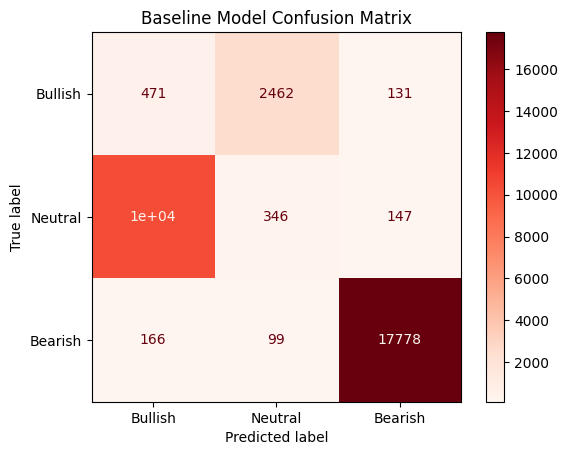

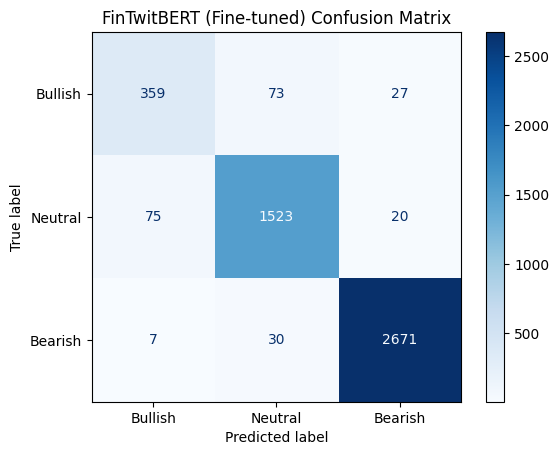

In [43]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load original labeled data and both prediction results
actual_df = pd.read_csv("filtered_dataset.csv")  # True labels
baseline_df = pd.read_csv("predicted_tweet_sentiments.csv")  # Baseline model predictions
fintwitbert_df = pd.read_csv("fintwitbert_test_predictions.csv")  # Fine-tuned model predictions

# Step 1: Merge actual and baseline predictions on tweet
baseline_merged = pd.merge(actual_df, baseline_df, on="tweet")

# Step 2: Map text labels from baseline to numeric
def map_baseline_label(label):
    label = label.upper()
    if label == "BULLISH":
        return 0
    elif label == "NEUTRAL":
        return 1
    elif label == "BEARISH":
        return 2
    else:
        return -1

baseline_merged["baseline_mapped"] = baseline_merged["predicted_label"].apply(map_baseline_label)

# Step 3: Merge FinTwitBERT predictions using tweet text (test set only)
fintwitbert_merged = pd.merge(
    fintwitbert_df[["tweet", "FinTwitBERT_prediction"]],
    actual_df[["tweet", "sentiment"]],
    on="tweet"
)

# Step 4: Add correctness column to each
baseline_merged["baseline_correct"] = baseline_merged["sentiment"] == baseline_merged["baseline_mapped"]
fintwitbert_merged["fintwitbert_correct"] = (
    fintwitbert_merged["sentiment"] == fintwitbert_merged["FinTwitBERT_prediction"]
)

# Step 5: Calculate and print accuracy
baseline_acc = accuracy_score(baseline_merged["sentiment"], baseline_merged["baseline_mapped"])
fintwitbert_acc = accuracy_score(fintwitbert_merged["sentiment"], fintwitbert_merged["FinTwitBERT_prediction"])

print(f"Baseline Model Accuracy: {baseline_acc * 100:.2f}%")
print(f"FinTwitBERT (Fine-tuned) Accuracy: {fintwitbert_acc * 100:.2f}%")

# Step 6: Confusion matrix plots
baseline_cm = confusion_matrix(baseline_merged["sentiment"], baseline_merged["baseline_mapped"])
fintwitbert_cm = confusion_matrix(fintwitbert_merged["sentiment"], fintwitbert_merged["FinTwitBERT_prediction"])

import matplotlib.pyplot as plt

# Plot for baseline model
disp1 = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=["Bullish", "Neutral", "Bearish"])
disp1.plot(cmap="Reds")
plt.title("Baseline Model Confusion Matrix")
plt.show()

# Plot for fine-tuned FinTwitBERT
disp2 = ConfusionMatrixDisplay(confusion_matrix=fintwitbert_cm, display_labels=["Bullish", "Neutral", "Bearish"])
disp2.plot(cmap="Blues")
plt.title("FinTwitBERT (Fine-tuned) Confusion Matrix")
plt.show()
